**Traing DeepCell Model and Make Predictions**<br>
It trains a model with three heads: inner distance, outer distance, and fgbg. It works on tensorflow 2.7.1.<br>
Tissuenet V1.0 dataset is used, which has images of size 512x512 in the "Intro to DeepCell" are 256x256. In contrast, the pretrained model in NuclearApplication was trained on images of 512x512.<br>
Training can also be done via deepcell.training.train_model_sample, which allows arbitrary size images and uses window_size to control patch size.

In [ ]:
import syotil

import numpy as np
from skimage import io
from matplotlib import pyplot as plt
%matplotlib inline
from timeit import default_timer

import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import MSE

import deepcell
from deepcell.utils.train_utils import rate_scheduler, get_callbacks, count_gpus
from deepcell.losses import weighted_categorical_crossentropy
from deepcell.model_zoo.panopticnet import PanopticNet
from deepcell_toolbox.deep_watershed import deep_watershed
from deepcell import image_generators

print(tf.__version__)

In [2]:
train_dict = np.load('/fh/fast/fong_y/tissuenet_v1.0/tissuenet_v1.0_train.npz')
train_X, train_y = train_dict['X'], train_dict['y']

# # val is 256x256, thus not used
# val_dict = np.load('/fh/fast/fong_y/tissuenet_v1.0/tissuenet_v1.0_val.npz')
# X_val, y_val = val_dict['X'], val_dict['y']

In [119]:
model_name = 'tn1.0_nuclear'; idx_X=0; idx_y=1
model_path = '{}.h5'.format(model_name)
#model_name = 'tn1.0_cyto'; idx.X=1; idx.y=0

seed = 0 
n=train_X.shape[0]

min_objects = 2

val_size = 0.2 # fraction of data saved as validation

import random
tmp = random.sample(range(n), int(val_size*n))

X_val = np.expand_dims(train_X[tmp,:,:,idx_X], axis=-1)
y_val = np.expand_dims(train_y[tmp,:,:,idx_y], axis=-1)

tmp1 = list(set(range(n)).difference (set(tmp)))
X_train = np.expand_dims(train_X[tmp1,:,:,idx_X], axis=-1)
y_train = np.expand_dims(train_y[tmp1,:,:,idx_y], axis=-1)

print('X_train.shape: {}\nX_val.shape: {}'.format(
    X_train.shape, X_val.shape))
transforms = ['inner-distance', 'outer-distance', 'fgbg']
transforms_kwargs = {'outer-distance': {'erosion_width': 0}}


# use augmentation for training but not validation
datagen = image_generators.SemanticDataGenerator(
    rotation_range=180,
    fill_mode='reflect',
    zoom_range=(0.75, 1.25),
    horizontal_flip=True,
    vertical_flip=True)

datagen_val = image_generators.SemanticDataGenerator()

batch_size = 4 # 8 causes memory outage

train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)

val_data = datagen_val.flow(
    {'X': X_val, 'y': y_val},
    seed=seed,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)

X_train.shape: (2081, 512, 512, 1)
X_val.shape: (520, 512, 512, 1)


/app/software/scikit-image/0.19.1-foss-2021b/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


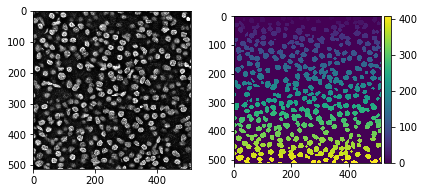

In [113]:
i=5
plt.subplot(1, 2, 1) # row 1, col 2 index 1
io.imshow(X_train[i,:,:,0])
plt.subplot(1, 2, 2) # row 1, col 2 index 1
# tmp = syotil.masks_to_outlines(y_train[i,:,:,0]); io.imshow(tmp)
io.imshow(y_train[i,:,:,0])
plt.show()

**The two cells below train the model and can be skipped if trained model will be loaded.**

In [114]:
semantic_classes = [1, 1, 2] # inner distance, outer distance, fgbg

model = PanopticNet(
    backbone='resnet50',
    input_shape=X_train.shape[1:],
    norm_method='whole_image',
    num_semantic_classes=semantic_classes)

lr = 1e-4
optimizer = Adam(lr=lr, clipnorm=0.001)
lr_sched = rate_scheduler(lr=lr, decay=0.99)

# Create a dictionary of losses for each semantic head

def semantic_loss(n_classes):
    def _semantic_loss(y_pred, y_true):
        if n_classes > 1:
            return 0.01 * weighted_categorical_crossentropy(
                y_pred, y_true, n_classes=n_classes)
        return MSE(y_pred, y_true)
    return _semantic_loss

loss = {}

# Give losses for all of the semantic heads
for layer in model.layers:
    if layer.name.startswith('semantic_'):
        n_classes = layer.output_shape[-1]
        loss[layer.name] = semantic_loss(n_classes)
        
model.compile(loss=loss, optimizer=optimizer)

[(layer.name, layer.output_shape) for layer in filter(lambda x: x.name.startswith('semantic_'), model.layers)]

2022-10-31 20:11:25.276232: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-10-31 20:11:36.489304: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14657 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:04:00.0, compute capability: 7.0
2022-10-31 20:11:36.500164: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14657 MB memory:  -> device: 1, name: Tesla V100-PCIE-16GB, pci bus id: 0000:06:00.0, compute capability: 7.0
2022-10-31 20:11:36.501358: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 14657 MB memory:  -> device: 2, name: Tesla V100-PCIE-16GB, pci bus id: 0000:08:00.0, compute capability: 7.0
/app/software/TensorFlow/2.7.1-foss-2021b

[('semantic_0', (None, 512, 512, 1)),
 ('semantic_1', (None, 512, 512, 1)),
 ('semantic_2', (None, 512, 512, 2))]

In [120]:
# fit the model
print('Training on', count_gpus(), 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
    monitor='val_loss',
    verbose=1)

loss_history = model.fit(
    train_data,
    steps_per_epoch=train_data.y.shape[0] // batch_size,
    epochs=60, # about 6 epochs/hr
    validation_data=val_data,
    validation_steps=val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

Training on 3 GPUs.


2022-10-31 20:14:49.099508: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 14657 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:04:00.0, compute capability: 7.0
2022-10-31 20:14:49.100694: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:1 with 14657 MB memory:  -> device: 1, name: Tesla V100-PCIE-16GB, pci bus id: 0000:06:00.0, compute capability: 7.0
2022-10-31 20:14:49.101966: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:2 with 14657 MB memory:  -> device: 2, name: Tesla V100-PCIE-16GB, pci bus id: 0000:08:00.0, compute capability: 7.0


Epoch 1/2
520/520 [==============================] - ETA: 0s - loss: 0.0403 - semantic_0_loss: 0.0205 - semantic_1_loss: 0.0180 - semantic_2_loss: 0.0019
Epoch 00001: val_loss improved from inf to 0.13796, saving model to tn1.0_nuclear.h5


/app/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


520/520 [==============================] - 613s 1s/step - loss: 0.0403 - semantic_0_loss: 0.0205 - semantic_1_loss: 0.0180 - semantic_2_loss: 0.0019 - val_loss: 0.1380 - val_semantic_0_loss: 0.0348 - val_semantic_1_loss: 0.0776 - val_semantic_2_loss: 0.0256 - lr: 1.0000e-04
Epoch 2/2
520/520 [==============================] - ETA: 0s - loss: 0.0133 - semantic_0_loss: 0.0058 - semantic_1_loss: 0.0063 - semantic_2_loss: 0.0012
Epoch 00002: val_loss improved from 0.13796 to 0.01121, saving model to tn1.0_nuclear.h5
520/520 [==============================] - 601s 1s/step - loss: 0.0133 - semantic_0_loss: 0.0058 - semantic_1_loss: 0.0063 - semantic_2_loss: 0.0012 - val_loss: 0.0112 - val_semantic_0_loss: 0.0051 - val_semantic_1_loss: 0.0052 - val_semantic_2_loss: 9.5388e-04 - lr: 9.9000e-05


<B>Make predictions on Nuclear test dataset.</B> 

In [121]:
# create prediction model

prediction_model = PanopticNet(
    backbone='resnet50',
    norm_method='whole_image',
    num_semantic_classes=[1, 1], # inner distance, outer distance
    input_shape=X_val.shape[1:]
)

prediction_model.load_weights(model_path, by_name=True)

In [122]:
# make predictions on validation data

start = default_timer()
test_images = prediction_model.predict(X_val)
watershed_time = default_timer() - start

print('Watershed segmentation of shape', test_images[0].shape,
      'in', watershed_time, 'seconds.')

masks = deep_watershed(
    test_images,
    min_distance=10,
    detection_threshold=0.1,
    distance_threshold=0.01,
    exclude_border=False,
    small_objects_threshold=0)


2022-10-31 20:35:32.572546: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-10-31 20:35:32.572625: W tensorflow/core/kernels/gpu_utils.cc:49] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
2022-10-31 20:35:42.756513: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.00GiB (rounded to 4294967296)requested by op panopticnet/batch_normalization_0_semantic_1/FusedBatchNormV3
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary 

ResourceExhaustedError:  OOM when allocating tensor with shape[32,128,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node panopticnet/batch_normalization_0_semantic_1/FusedBatchNormV3
 (defined at /app/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/layers/normalization/batch_normalization.py:605)
]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_52801]

Errors may have originated from an input operation.
Input Source operations connected to node panopticnet/batch_normalization_0_semantic_1/FusedBatchNormV3:
In[0] panopticnet/conv_0_semantic_1/BiasAdd (defined at /app/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/layers/convolutional.py:264)	
In[1] panopticnet/batch_normalization_0_semantic_1/ReadVariableOp:	
In[2] panopticnet/batch_normalization_0_semantic_1/ReadVariableOp_1:	
In[3] panopticnet/batch_normalization_0_semantic_1/FusedBatchNormV3/ReadVariableOp:	
In[4] panopticnet/batch_normalization_0_semantic_1/FusedBatchNormV3/ReadVariableOp_1:

Operation defined at: (most recent call last)
>>>   File "/app/software/Python/3.9.6-GCCcore-11.2.0/lib/python3.9/runpy.py", line 197, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/app/software/Python/3.9.6-GCCcore-11.2.0/lib/python3.9/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/app/software/IPython/7.26.0-GCCcore-11.2.0/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/app/software/IPython/7.26.0-GCCcore-11.2.0/lib/python3.9/site-packages/traitlets/config/application.py", line 845, in launch_instance
>>>     app.start()
>>> 
>>>   File "/app/software/IPython/7.26.0-GCCcore-11.2.0/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 667, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/app/software/bokeh/2.4.2-foss-2021b/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/app/software/Python/3.9.6-GCCcore-11.2.0/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/app/software/Python/3.9.6-GCCcore-11.2.0/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
>>>     handle._run()
>>> 
>>>   File "/app/software/Python/3.9.6-GCCcore-11.2.0/lib/python3.9/asyncio/events.py", line 80, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/app/software/IPython/7.26.0-GCCcore-11.2.0/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 456, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "/app/software/IPython/7.26.0-GCCcore-11.2.0/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 445, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "/app/software/IPython/7.26.0-GCCcore-11.2.0/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 352, in dispatch_shell
>>>     await result
>>> 
>>>   File "/app/software/IPython/7.26.0-GCCcore-11.2.0/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 647, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "/app/software/IPython/7.26.0-GCCcore-11.2.0/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 345, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/app/software/IPython/7.26.0-GCCcore-11.2.0/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "/app/software/IPython/7.26.0-GCCcore-11.2.0/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2898, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/app/software/IPython/7.26.0-GCCcore-11.2.0/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2944, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/app/software/IPython/7.26.0-GCCcore-11.2.0/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/app/software/IPython/7.26.0-GCCcore-11.2.0/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3169, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/app/software/IPython/7.26.0-GCCcore-11.2.0/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3361, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "/app/software/IPython/7.26.0-GCCcore-11.2.0/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "/tmp/ipykernel_27136/20299914.py", line 4, in <module>
>>>     test_images = prediction_model.predict(X_val)
>>> 
>>>   File "/app/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/app/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/engine/training.py", line 1789, in predict
>>>     tmp_batch_outputs = self.predict_function(iterator)
>>> 
>>>   File "/app/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/engine/training.py", line 1621, in predict_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/app/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/engine/training.py", line 1611, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/app/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/engine/training.py", line 1604, in run_step
>>>     outputs = model.predict_step(data)
>>> 
>>>   File "/app/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/engine/training.py", line 1572, in predict_step
>>>     return self(x, training=False)
>>> 
>>>   File "/app/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/app/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/app/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/app/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/engine/functional.py", line 451, in call
>>>     return self._run_internal_graph(
>>> 
>>>   File "/app/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "/app/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/app/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/app/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/app/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/layers/normalization/batch_normalization.py", line 767, in call
>>>     outputs = self._fused_batch_norm(inputs, training=training)
>>> 
>>>   File "/app/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/layers/normalization/batch_normalization.py", line 623, in _fused_batch_norm
>>>     output, mean, variance = control_flow_util.smart_cond(
>>> 
>>>   File "/app/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/utils/control_flow_util.py", line 105, in smart_cond
>>>     return tf.__internal__.smart_cond.smart_cond(
>>> 
>>>   File "/app/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/layers/normalization/batch_normalization.py", line 605, in _fused_batch_norm_inference
>>>     return tf.compat.v1.nn.fused_batch_norm(
>>> 

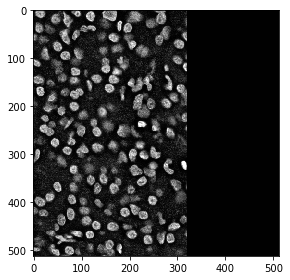

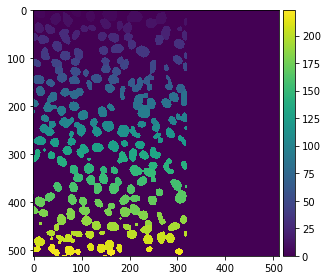

(520, 512, 512, 1)
(520, 512, 512, 1)


In [123]:
io.imshow(X_val[1,:,:,0])
plt.show()
io.imshow(y_val[1,:,:,0])
plt.show()
print(X_val.shape)
print(y_val.shape)

In [124]:
APs = [syotil.csi(y_val[i,:,:,0], masks[i,:,:,0]) for i in range(y_val.shape[0])]
print(np.nanmean(APs))

NameError: name 'masks' is not defined

**Make prediction on K's data.**<br>
Using NuclearSegmentation allows setting image_mpp, which has a substantial influence on performance.

In [125]:
from deepcell.applications import NuclearSegmentation

app = NuclearSegmentation(prediction_model)
[(layer.name, layer.output_shape) for layer in filter(lambda x: x.name.startswith('semantic_'), app.model.layers)]

[('semantic_0', (None, 512, 512, 1)), ('semantic_1', (None, 512, 512, 1))]

(1040, 233)


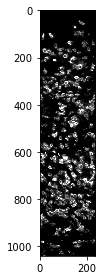

(1040, 233)


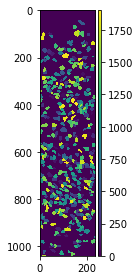

In [126]:
# a rectangular patch that requires tiling
im0 = io.imread('images/test/M872956_JML_Position8_CD3_test_img.png')
print(im0.shape)
im=im0
io.imshow(im)
plt.show()
im = np.expand_dims(im, axis=-1)
im = np.expand_dims(im, axis=0)

mask_true=io.imread("images/test/M872956_JML_Position8_CD3_test_masks.png")
print(mask_true.shape)
io.imshow(mask_true)
plt.show()

In [127]:
app.model_image_shape

(512, 512, 1)

(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}


/app/software/DeepCell/0.11.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/deepcell_toolbox/deep_watershed.py:179: FutureWarning: `selem` is a deprecated argument name for `h_maxima`. It will be removed in version 1.0.Please use `footprint` instead.
  markers = h_maxima(image=maxima,


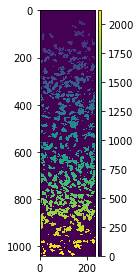

0.1742354031510658

In [128]:
x=im
y, tile_info = app._tile_input(im)
print(x.shape)
print(y.shape)
print(tile_info)
pred = app.predict(y, image_mpp=2)
prd = app._untile_output(pred, tile_info)
io.imshow(prd[0,:,:,0])
plt.show()
syotil.csi(mask_true, prd[0,:,:,0])
# image_mpp=1: .2
# image_mpp=2: .3
# image_mpp=3 .1

**Additional testing with a square patch.**

In [ ]:
# read CD3 data

img=io.imread("images/square_patches/M872956_JML_Position8_CD3_img_patch256x256.png")
print(img.shape)
X_cd3=img[:,:,2]
#io.imshow(im)
#plt.show()
X_cd3=np.expand_dims(X_cd3, -1) 
X_cd3=np.expand_dims(X_cd3, 0) 

y_cd3=io.imread("images/square_patches/M872956_JML_Position8_CD3_masks_patch256x256.png")
print(y_cd3.shape)
#io.imshow(mask_true)
#plt.show()
y_cd3=np.expand_dims(y_cd3, -1) 
y_cd3=np.expand_dims(y_cd3, 0) 

batch_size_cd3 = 1

print(X_cd3.shape)
print(y_cd3.shape)

train_cd3 = datagen.flow(
    {'X': X_cd3, 'y': y_cd3},
    seed=seed,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)

val_cd3 = datagen_val.flow(
    {'X': X_cd3, 'y': y_cd3},
    seed=seed,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)

In [ ]:
y, tile_info = app._tile_input(X_cd3)
print(y.shape)
#print(tile_info)
pred = app.predict(y, image_mpp=1)  #, image_mpp=1 0.299, with default image_mpp 0.65, it is 0.09
prd = app._untile_output(pred, tile_info)
io.imshow(prd[0,:,:,0])
plt.show()
syotil.csi(y_cd3[0,:,:,0], prd[0,:,:,0]) # 

**Predictions can also be made without Application.**<br>
Don't set min_distance to 0.

In [ ]:
# make predictions on CD3 data
start = default_timer()
test_images = prediction_model.predict(X_cd3)
watershed_time = default_timer() - start

pred_cd3 = deep_watershed(
    test_images,
    min_distance=10, # this should not be set to 0, https://github.com/vanvalenlab/deepcell-toolbox/blob/master/deepcell_toolbox/deep_watershed.py
    detection_threshold=0.001,
    distance_threshold=0.0,
    exclude_border=False,
    small_objects_threshold=0)

#print(y_cd3.shape, pred_cd3.shape)
# io.imshow(y_cd3[0,:,:,0])
# plt.show()
io.imshow(pred_cd3[0,:,:,0])
plt.show()

syotil.csi(y_cd3[0,:,:,0], pred_cd3[0,:,:,0])